# Explanation Module (Visual-based XAI)


In [ ]:
# Copyright 2025 Claudio Giovannoni, Carlo Metta, Anna Monreale,
# Salvatore Rinzivillo, Andrea Berti, Sara Colantonio, and
# Francesca Pratesi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/gdrive')
import shutil
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.models import load_model
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/code/')

Mounted at /content/gdrive


# GradCam

In [ ]:
# Specify the path to your saved .h5 model file
model_path = '/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/binary_best_model_imagenet_new.h5'

# Load the model
model = load_model(model_path, compile=False)

In [ ]:
optimizer = SGD(learning_rate=1e-3, momentum = 0.9)
model.compile(optimizer=optimizer,
              loss= wbce(7,3),
              metrics=['accuracy', 'AUC'])

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set using the model
predictions = model.predict(valid_data)
predicted_labels = np.round(predictions).astype(int)

# Generate the classification report
report = classification_report(y_valid,
                               predicted_labels,
                               target_names=['Class 0', 'Class 1'])
print(report)

700/700 [==============================] - 16s 22ms/step
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94       497
     Class 1       0.84      0.88      0.86       203

    accuracy                           0.92       700
   macro avg       0.90      0.91      0.90       700
weighted avg       0.92      0.92      0.92       700



In [ ]:
x = y_valid-predicted_labels

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_grads_0 = grads[:, :, 0]
    pooled_grads_1 = grads[:, :, 1]
    pooled_grads_2 = grads[:, :, 2]

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap_0 = last_conv_layer_output @ pooled_grads_0[..., tf.newaxis]
    heatmap_1 = last_conv_layer_output @ pooled_grads_1[..., tf.newaxis]
    heatmap_2 = last_conv_layer_output @ pooled_grads_2[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap_0 = tf.squeeze(heatmap_0)
    heatmap_1 = tf.squeeze(heatmap_1)
    heatmap_2 = tf.squeeze(heatmap_2)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap_0 = tf.maximum(heatmap_0, 0) / tf.math.reduce_max(heatmap_0)
    heatmap_1 = tf.maximum(heatmap_1, 0) / tf.math.reduce_max(heatmap_1)
    heatmap_2 = tf.maximum(heatmap_2, 0) / tf.math.reduce_max(heatmap_2)
    return heatmap.numpy(), heatmap_0.numpy(), heatmap_1.numpy(), heatmap_2.numpy()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.matmul(last_conv_layer_output, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def generate_channel_specific_heatmaps(img_array, model, last_conv_layer_name):
    # Ensure img_array is a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Initialize an empty list to store the heatmaps
    heatmaps = []

    # Generate a heatmap for each channel
    for i in range(3):  # Assuming img_array has shape (1, height, width, 3)
        modified_img_array = np.zeros_like(img_array)
        modified_img_array[0, :, :, i] = img_array[0, :, :, i]

        # Convert the modified image array to a tensor
        modified_img_tensor = tf.convert_to_tensor(modified_img_array, dtype=tf.float32)

        heatmap = make_gradcam_heatmap(modified_img_tensor, model, last_conv_layer_name)
        heatmaps.append(heatmap)

    # Calculate the average heatmap
    average_heatmap = np.mean(heatmaps, axis=0)
    heatmaps.append(average_heatmap)

    return heatmaps  # Returns a list of 4 heatmaps

# Rise

In [ ]:
import numpy as np
import tensorflow as tf

def generate_rise_masks(size=(64, 64), N=1000, s=8, p=0.5):
    """
    Generate RISE masks.
    size: Size of the input images (height, width).
    N: Number of masks to generate.
    s: Size of the cell in the mask grid.
    p: Probability of a cell being set to 1 (cell is active).
    """
    cell_size = np.ceil(np.array(size) / s).astype(int)  # Ensure cell_size is of integer type
    up_size = s * cell_size  # Corrected to ensure we cover the whole image when upsampling

    grid = np.random.rand(N, *cell_size) < p
    grid = grid.astype('float32')

    masks = np.zeros((N, *size))
    for i in range(N):
        # Resize each grid to match the input image size
        mask = tf.image.resize(grid[i][np.newaxis, ..., np.newaxis], size, method='nearest')[0, ..., 0]
        masks[i] = mask
    return masks

def apply_rise_masks(img_array, masks):
    """
    Apply RISE masks to the input image.
    img_array: Input image array.
    masks: Generated RISE masks.
    """
    N = masks.shape[0]
    masked = img_array * masks[:,:,:,np.newaxis]
    return masked, masks

def generate_rise_heatmaps(img_array, model, N=1000):
    """
    Generate heatmaps using the RISE method.
    img_array: Input image array with shape (1, height, width, 3).
    model: TensorFlow/Keras model.
    N: Number of masks to generate and apply.
    """
    size = img_array.shape[1:3]
    masks = generate_rise_masks(size=size, N=N)
    masked_images, masks = apply_rise_masks(img_array, masks)

    # Get model predictions for masked images
    preds = model.predict(masked_images, batch_size=32)

    # Compute saliency maps
    saliency_maps = np.tensordot(preds.squeeze(), masks, axes=[0, 0])
    saliency_map = np.mean(saliency_maps, axis=0)  # Average over all predictions

    # Generate channel-specific heatmaps (for demonstration)
    heatmaps = [saliency_map for _ in range(3)]  # Three identical channel-specific maps
    average_heatmap = np.mean(heatmaps, axis=0)  # Average heatmap (identical in this case)

    return [saliency_map] * 3 + [average_heatmap]

In [ ]:
# Example usage
# img_array = ... # Your input image with shape (1, height, width, 3)
# model = ... # Your TensorFlow/Keras model
# heatmaps = generate_rise_heatmaps(img_array, model, N=1000)

In [ ]:
i = -55
y_valid[i], predictions[i], X_valid[i].shape

(array([1]), array([0.99999726], dtype=float32), (64, 64, 3))

In [ ]:
last_conv_layer_name = "conv1_conv"

img_array = X_valid[i]
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)

heatmaps = generate_rise_heatmaps(img_array, model, N=1000)

32/32 [==============================] - 6s 149ms/step


# LRP

In [ ]:
def generate_channel_specific_relevance_maps(img_array, model, last_conv_layer_name):
    """
    Generates relevance maps for each channel using Layer-wise Relevance Propagation.
    NOTE: This is a conceptual template. Actual implementation requires custom layer modifications.
    """
    # Placeholder function for LRP implementation on a model
    # This should be replaced with an actual LRP algorithm applicable to your model
    def lrp_model(model, img_tensor, target_layer):
        # Implement LRP here, returning a relevance map for the input image
        # The relevance map should highlight the input features contributing to the model's output
        relevance_map = img_tensor  # Placeholder line, replace with actual relevance computation
        return relevance_map

    # Ensure img_array has a batch dimension
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)

    # Convert img_array to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Initialize an empty list to store the relevance maps
    relevance_maps = []

    # Generate a relevance map for each channel
    for i in range(3):  # Assuming img_array has shape (1, height, width, 3)
        # Ideally, LRP should be calculated for each channel's contribution to the output
        # Here, we conceptually isolate the input per channel (this might not be directly applicable in LRP)
        channel_mask = np.zeros_like(img_tensor)
        channel_mask[:, :, :, i] = 1
        modified_img_tensor = img_tensor * channel_mask

        # Compute the LRP relevance map for the modified image tensor
        relevance_map = lrp_model(model, modified_img_tensor, last_conv_layer_name)
        relevance_maps.append(relevance_map.numpy()[0])  # Adjust as per actual LRP output

    # Calculate the average relevance map
    average_relevance_map = np.mean(relevance_maps, axis=0)
    relevance_maps.append(average_relevance_map)

    return relevance_maps  # Returns a list of 4 relevance maps

In [ ]:
# Usage example:
# img_array should be your input image tensor with shape (1, height, width, 3)
# model is your TensorFlow/Keras model
# last_conv_layer_name is the name of the first convolutional layer or the layer of interest
# relevance_maps = generate_channel_specific_relevance_maps(img_array, model, 'conv1_conv')

# Explainer

In [ ]:
i = -55
y_valid[i], predictions[i], X_valid[i].shape

(array([1]), array([0.99999726], dtype=float32), (64, 64, 3))

In [ ]:
last_conv_layer_name = "conv1_conv"

img_array = X_valid[i]
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)

heatmaps = generate_channel_specific_relevance_maps(img_array, model, last_conv_layer_name)

1/1 [==============================] - 0s 41ms/step


In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
i = -55
y_valid[i], predictions[i], X_valid[i].shape

(array([1]), array([0.99999726], dtype=float32), (64, 64, 3))

In [ ]:
#last_conv_layer_name = "conv5_block3_3_conv"
last_conv_layer_name = "conv1_conv"

img_array = X_valid[i]
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)

heatmaps = generate_channel_specific_heatmaps(img_array, model, last_conv_layer_name)

1/1 [==============================] - 0s 40ms/step


In [ ]:
def renormalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val)

In [ ]:
heatmaps[0].shape

(64,)

Image shape: (64, 64)


TypeError: Invalid shape (64,) for image data

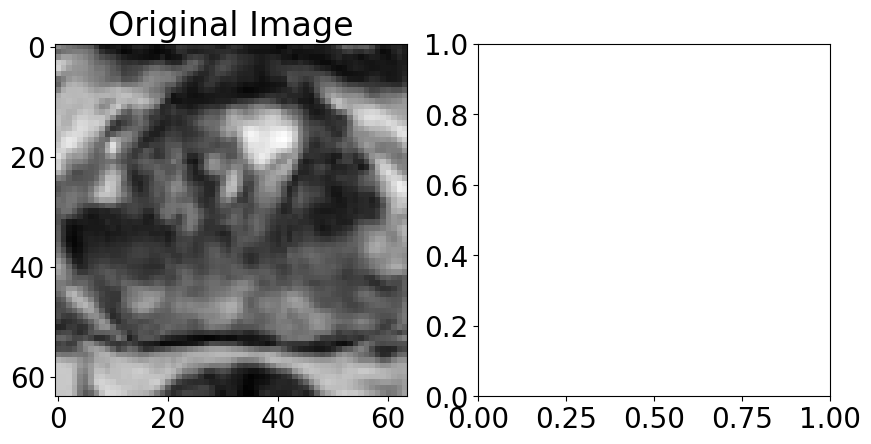

In [ ]:
img = renormalize(X_valid[i][:, :, 0])
if img is not None:
    print("Image shape:", img.shape)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')

    #heatmap0 = renormalize(heatmaps[0][:,:,0])
    #if heatmap.ndim == 3 and heatmap.shape[2] == 1:
        #heatmap = np.squeeze(heatmap)  # Remove singleton third dimension

    # Plot the preprocessed image
    axs[1].imshow(heatmaps[0])
    axs[1].set_title('Heat map')

    # Display the subplots
    plt.show()
else:
    print("Failed to load image.")

Image shape: (64, 64)


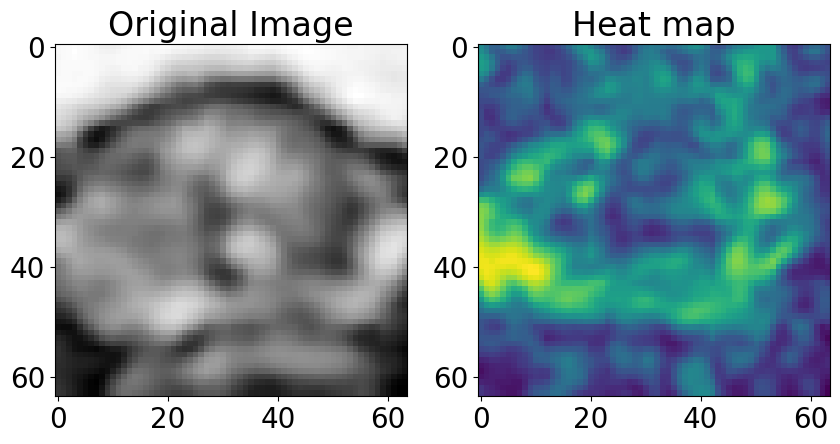

In [ ]:
img = renormalize(X_valid[i][:, :, 1])
if img is not None:
    print("Image shape:", img.shape)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')

    heatmap1 = renormalize(heatmaps[1][:,:,1])
    if heatmap.ndim == 3 and heatmap.shape[2] == 1:
        heatmap = np.squeeze(heatmap)  # Remove singleton third dimension

    # Plot the preprocessed image
    axs[1].imshow(renormalize(heatmap))
    axs[1].set_title('Heat map')

    # Display the subplots
    plt.show()
else:
    print("Failed to load image.")

Image shape: (64, 64)


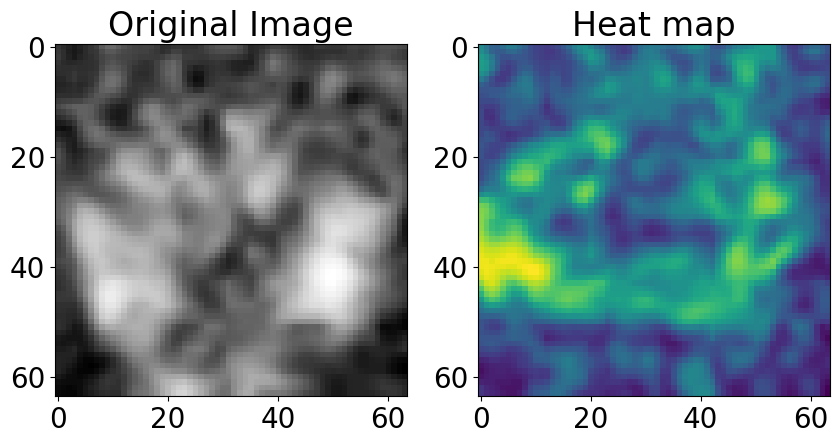

In [ ]:
img = renormalize(X_valid[i][:, :, 2])
if img is not None:
    print("Image shape:", img.shape)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')

    heatmap2 = renormalize(heatmaps[2][:,:,2])
    if heatmap.ndim == 3 and heatmap.shape[2] == 1:
        heatmap = np.squeeze(heatmap)  # Remove singleton third dimension

    # Plot the preprocessed image
    axs[1].imshow(renormalize(heatmap))
    axs[1].set_title('Heat map')

    # Display the subplots
    plt.show()
else:
    print("Failed to load image.")

In [ ]:
from PIL import Image

heatmaps0 = Image.fromarray((heatmaps[0] * 255).astype(np.uint8))
resized_heatmap0 = heatmaps0.resize((64, 64), Image.ANTIALIAS)
resized_heatmap0 = np.array(resized_heatmap0)

heatmaps1 = Image.fromarray((heatmaps[1] * 255).astype(np.uint8))
resized_heatmap1 = heatmaps1.resize((64, 64), Image.ANTIALIAS)
resized_heatmap1 = np.array(resized_heatmap1)

heatmaps2 = Image.fromarray((heatmaps[2] * 255).astype(np.uint8))
resized_heatmap2 = heatmaps2.resize((64, 64), Image.ANTIALIAS)
resized_heatmap2 = np.array(resized_heatmap2)

heatmaps3 = Image.fromarray((heatmaps[3] * 255).astype(np.uint8))
resized_heatmap3 = heatmaps3.resize((64, 64), Image.ANTIALIAS)
resized_heatmap3 = np.array(resized_heatmap3)



<ipython-input-188-804cb9c5f8e0>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_heatmap0 = heatmaps0.resize((64, 64), Image.ANTIALIAS)
<ipython-input-188-804cb9c5f8e0>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_heatmap1 = heatmaps1.resize((64, 64), Image.ANTIALIAS)
<ipython-input-188-804cb9c5f8e0>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_heatmap2 = heatmaps2.resize((64, 64), Image.ANTIALIAS)
<ipython-input-188-804cb9c5f8e0>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_heatmap3 = heatmaps3.resize((64, 64), Image.ANTIALIAS)


In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/images/lesion_slices/valid/11299_1001322_slice15_crop.png'

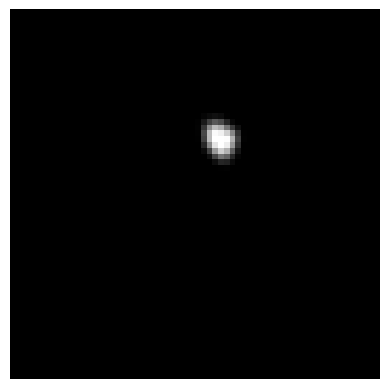

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(path)

# Plot the image
plt.imshow(img)
plt.axis('off')  # Hide the axes if you prefer
plt.show()

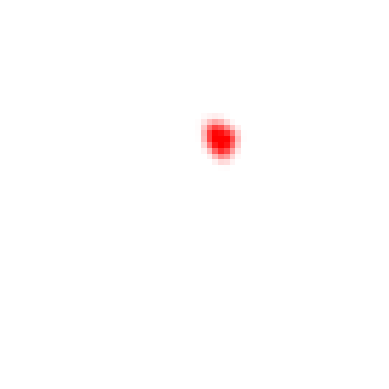

In [ ]:
# Ensure the image is in grayscale format, i.e., 2D array
if img.ndim == 3 and img.shape[2] in [3, 4]:
    img = np.mean(img[:, :, :3], axis=2)  # Convert to grayscale by averaging the RGB values

# Create an output image in RGB format initialized to white
red_img = np.ones((img.shape[0], img.shape[1], 3))

# Adjust the output image to transition from white to red
# The logic here is to decrease the green and blue channels based on the intensity of the grayscale image
# Higher intensity in the grayscale means a higher value in the red channel and lower in green and blue, resulting in a shade closer to red
# Lower intensity means higher values in green and blue, maintaining the white color
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        intensity = img[i, j] / np.max(img)  # Normalize intensity to the range [0, 1]
        red_img[i, j, 1] = 1 - intensity  # Decrease green based on intensity
        red_img[i, j, 2] = 1 - intensity  # Decrease blue based on intensity

# Display the result
plt.imshow(red_img)
plt.axis('off')
plt.show()

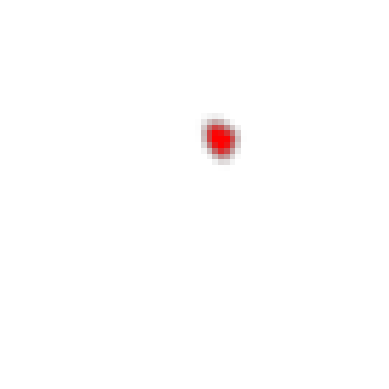

In [ ]:
# Convert to grayscale if it's not already
if img.ndim == 3 and img.shape[2] in [3, 4]:  # RGB or RGBA
    img = np.mean(img[:, :, :3], axis=2)  # Convert to grayscale

# Normalize the image to have values between 0 and 1 if not already
if img.max() > 1.0:
    img = img / 255.0

# Create an RGBA image: start with zeros (transparent)
rgba_img = np.zeros((img.shape[0], img.shape[1], 4))

# Set red channel and alpha channel based on the grayscale intensity
rgba_img[:, :, 0] = img  # Red channel
rgba_img[:, :, 3] = img  # Alpha channel for transparency

# Plot the image
plt.imshow(rgba_img)
plt.axis('off')  # Optional: hides the axis
plt.show()

Image shape: (64, 64)


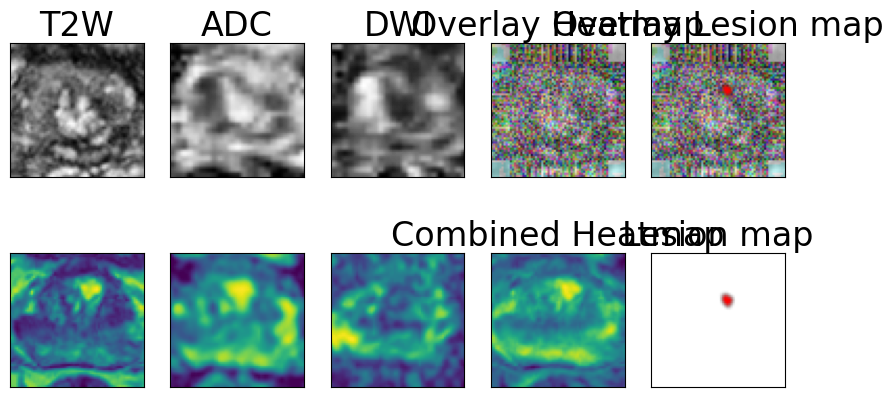

In [ ]:
img_0 = renormalize(X_valid[-1][:, :, 0])
img_1 = renormalize(X_valid[-1][:, :, 1])
img_2 = renormalize(X_valid[-1][:, :, 2])

if img is not None:
    print("Image shape:", img.shape)

    # Create subplots
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))

    # Plot the original image
    axs[0,0].imshow(img_0, cmap='gray')
    axs[0,0].set_title('T2W')
    axs[0,0].set_xticks([])  # Remove x-axis ticks
    axs[0,0].set_yticks([])  # Remove y-axis ticks
    # Plot the original image
    axs[0,1].imshow(img_1, cmap='gray')
    axs[0,1].set_title('ADC')
    axs[0,1].set_xticks([])  # Remove x-axis ticks
    axs[0,1].set_yticks([])  # Remove y-axis ticks
    # Plot the original image
    axs[0,2].imshow(img_2, cmap='gray')
    axs[0,2].set_title('DWI')
    axs[0,2].set_xticks([])  # Remove x-axis ticks
    axs[0,2].set_yticks([])  # Remove y-axis ticks

    axs[0,3].imshow(img_0, cmap='gray')  # Show the original image first
    axs[0,3].imshow(resized_heatmap3, alpha=0.6)  # Overlay the heatmap
    axs[0,3].set_title('Overlay Heatmap')
    axs[0,3].set_xticks([])  # Remove x-axis ticks
    axs[0,3].set_yticks([])  # Remove y-axis ticks

    axs[0,4].imshow(img_0, cmap='gray')  # Show the original image first
    axs[0,4].imshow(resized_heatmap3, alpha=0.6)  # Overlay the heatmap
    axs[0,4].imshow(rgba_img, alpha=1)
    axs[0,4].set_title('Overlay Lesion map')
    axs[0,4].set_xticks([])  # Remove x-axis ticks
    axs[0,4].set_yticks([])  # Remove y-axis ticks

    # Plot the preprocessed image
    axs[1,0].imshow(heatmap0)
    #axs[1,0].set_title('Heat map')
    axs[1,0].set_xticks([])  # Remove x-axis ticks
    axs[1,0].set_yticks([])  # Remove y-axis ticks

    # Plot the preprocessed image
    axs[1,1].imshow(heatmap1)
    #axs[1,1].set_title('Heat map')
    axs[1,1].set_xticks([])  # Remove x-axis ticks
    axs[1,1].set_yticks([])  # Remove y-axis ticks

    # Plot the preprocessed image
    axs[1,2].imshow(heatmap2)
    #axs[1,2].set_title('Heat map')
    axs[1,2].set_xticks([])  # Remove x-axis ticks
    axs[1,2].set_yticks([])  # Remove y-axis ticks

    # Plot the preprocessed image
    axs[1,3].imshow(heatmap3)
    axs[1,3].set_title('Combined Heatmap')
    axs[1,3].set_xticks([])  # Remove x-axis ticks
    axs[1,3].set_yticks([])  # Remove y-axis ticks

    # Plot the preprocessed image
    axs[1,4].imshow(rgba_img)
    axs[1,4].set_title('Lesion map')
    axs[1,4].set_xticks([])  # Remove x-axis ticks
    axs[1,4].set_yticks([])  # Remove y-axis ticks



    # Display the subplots
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/comparison_ter.png', dpi = 300)
    plt.show()
else:
    print("Failed to load image.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a boolean mask for red pixels in 'red_img' considering it's white to red transition
red_pixels_mask_initial = np.logical_and(red_img[:, :, 1] < 1, red_img[:, :, 2] < 1)

# Since the shape difference is exactly 2:1, we can downsample by taking every second pixel
# This is a simple and effective method when we know the exact scale factor and want to avoid interpolation artifacts
red_pixels_mask = red_pixels_mask_initial[::2, ::2]

# Calculate the average density of 'heatmaps[3]' where 'red_img' is red
average_density = np.mean(heatmaps[3][red_pixels_mask])

# Calculate the "red" area, M
M = np.sum(red_pixels_mask)

# Identifying the top M active pixels in 'heatmaps[3]' and their overlap with the red area
flattened_heatmap = heatmaps[3].flatten()
sorted_indices = np.argsort(flattened_heatmap)[-M:]  # Indices of the top M values
rows, cols = np.unravel_index(sorted_indices, heatmaps[3].shape)  # Convert to 2D indices

# Create a flat mask to easily check if each of the top M active pixels falls within the red area
flat_red_pixels_mask = red_pixels_mask.flatten()
active_in_red = np.sum(flat_red_pixels_mask[sorted_indices])

print(f"Average density of heatmaps[3] in the red area: {average_density}")
print(f"Area (M) where red_img is red: {M} pixels")
print(f"Number of most active M points in heatmaps[3] that lie in the red area: {active_in_red}")

Average density of heatmaps[3] in the red area: 0.33015453815460205
Area (M) where red_img is red: 17 pixels
Number of most active M points in heatmaps[3] that lie in the red area: 0


In [ ]:
total = np.mean(heatmaps[3])*3
np.mean(heatmaps[0])/total, np.mean(heatmaps[1])/total, np.mean(heatmaps[2])/total

(0.008682413079156539, 0.20137161088332847, 0.7899459097959601)

In [ ]:
model.predict(img_array)

1/1 [==============================] - 0s 24ms/step


array([[0.9200976]], dtype=float32)

In [ ]:
y_valid[-1]


array([1])

In [ ]:
np.mean(heatmap), np.mean(heatmap_0), np.mean(heatmap_1), np.mean(heatmap_2)

(125.150390625, 0.113622256, 0.13554259, 0.08629146)

In [ ]:
X_valid[0]

array([[[31518,  6430, 35357],
        [34845,  8222, 34333],
        [35869, 10014, 31518],
        ...,
        [10526,  6430, 30750],
        [10014,  7966, 24350],
        [10782, 10014, 17694]],

       [[30238, 10270, 37405],
        [30750, 14878, 32798],
        [34077, 19230, 29470],
        ...,
        [ 8222, 12830, 37917],
        [ 8222, 12318, 29470],
        [ 8734, 13854, 20254]],

       [[32030,  5662, 19486],
        [41501,  8734, 14878],
        [38685, 10014, 12574],
        ...,
        [ 8222, 15902, 40477],
        [ 9246, 13598, 33053],
        [10782, 11550, 25374]],

       ...,

       [[ 9502,  5150, 11550],
        [13854,   542,   798],
        [20766,   798,  8222],
        ...,
        [20766, 24862, 23582],
        [10782, 12830, 26142],
        [ 7966,  2334, 27422]],

       [[ 9246,  4638, 18206],
        [ 8478,  2334,  7454],
        [14366,  1310,  7710],
        ...,
        [15646, 21534, 24094],
        [ 8478, 12830, 25374],
        [ 6942,

### Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set using the model
predictions = model.predict(valid_data)
predicted_labels = np.round(predictions).astype(int)

# Generate the classification report
report = classification_report(y_valid,
                               predicted_labels,
                               target_names=['Class 0', 'Class 1'])
print(report)

700/700 [==============================] - 15s 21ms/step
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94       497
     Class 1       0.84      0.88      0.86       203

    accuracy                           0.92       700
   macro avg       0.90      0.91      0.90       700
weighted avg       0.92      0.92      0.92       700



700/700 [==============================] - 15s 21ms/step


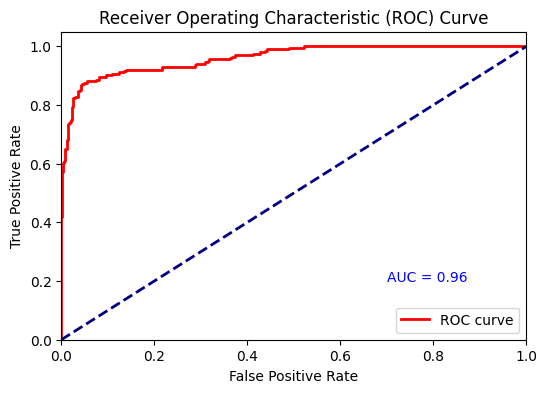

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
predicted_probs = model.predict(valid_data)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Display AUC value on the graph
plt.text(0.7, 0.2, f'AUC = {roc_auc:.2f}', fontsize=10, color='blue')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/auc_score_new.png', dpi = 300)
plt.show()

714/714 [==============================] - 4s 6ms/step


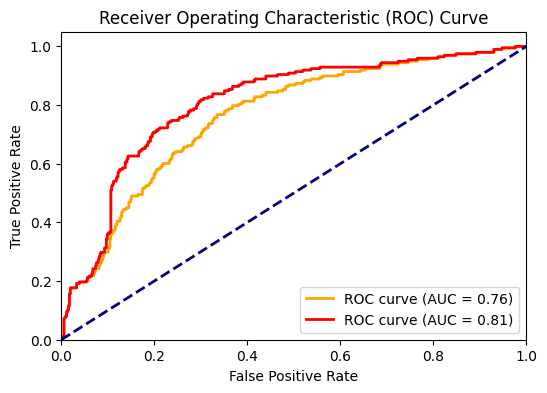

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
#predicted_probs = model.predict(valid_data)

predicted_probs1 = np.load('/content/gdrive/My Drive/Colab Notebooks/predict_proba_4.npy')
predicted_probs = model.predict(valid_data)
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid, predicted_probs)
roc_auc = auc(fpr, tpr)
fpr1, tpr1, thresholds1 = roc_curve(y_valid, predicted_probs1)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Display AUC value on the graph
#plt.text(0.7, 0.2, f'AUC = {roc_auc:.2f}', fontsize=10, color='blue')
#plt.text(0.7, 0.2, f'AUC = 0.80', fontsize=10, color='blue')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/auc_score_all.png', dpi = 300)
plt.show()

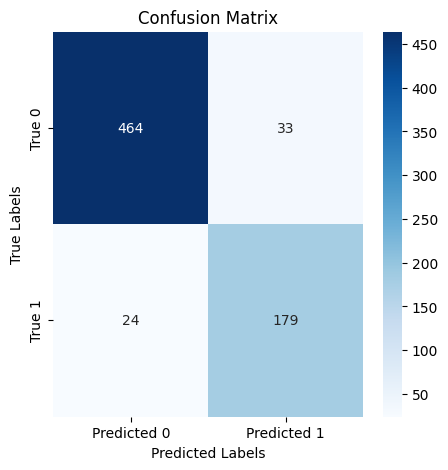

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
predicted_labels = (predicted_probs > 0.5).astype(int)  # Assuming binary classification with a threshold of 0.5

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

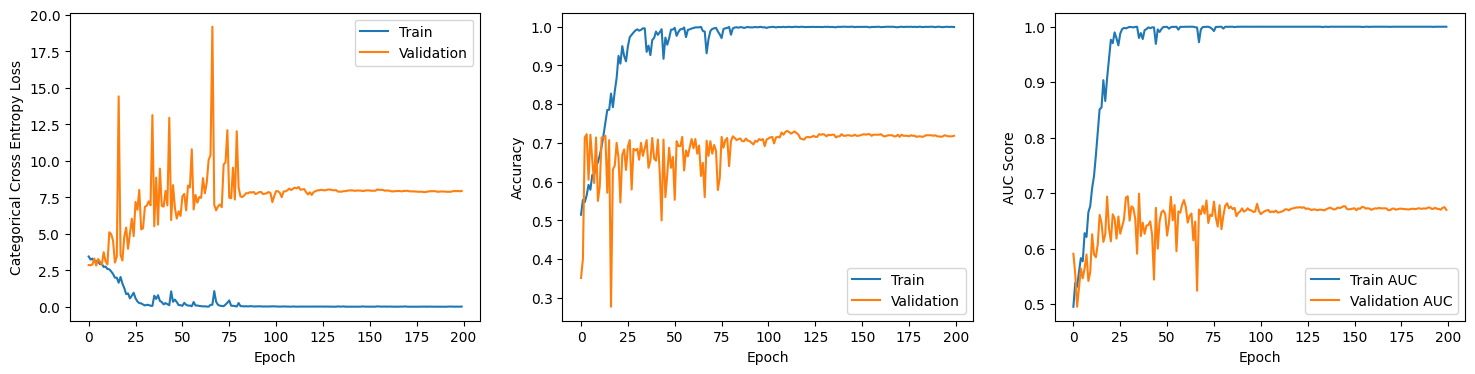

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_ylabel('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='best')

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='best')

axs[2].plot(history.history['auc'], label='Train AUC')
axs[2].plot(history.history['val_auc'], label='Validation AUC')
axs[2].set_ylabel('AUC Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='best')

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.matmul(last_conv_layer_output, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def generate_channel_specific_heatmaps(img_array, model, last_conv_layer_name):
    # Ensure img_array is a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Initialize an empty list to store the heatmaps
    heatmaps = []

    # Generate a heatmap for each channel
    for i in range(3):  # Assuming img_array has shape (1, height, width, 3)
        modified_img_array = np.zeros_like(img_array)
        modified_img_array[0, :, :, i] = img_array[0, :, :, i]

        # Convert the modified image array to a tensor
        modified_img_tensor = tf.convert_to_tensor(modified_img_array, dtype=tf.float32)

        heatmap = make_gradcam_heatmap(modified_img_tensor, model, last_conv_layer_name)
        heatmaps.append(heatmap)

    # Calculate the average heatmap
    average_heatmap = np.mean(heatmaps, axis=0)
    heatmaps.append(average_heatmap)

    return heatmaps  # Returns a list of 4 heatmaps

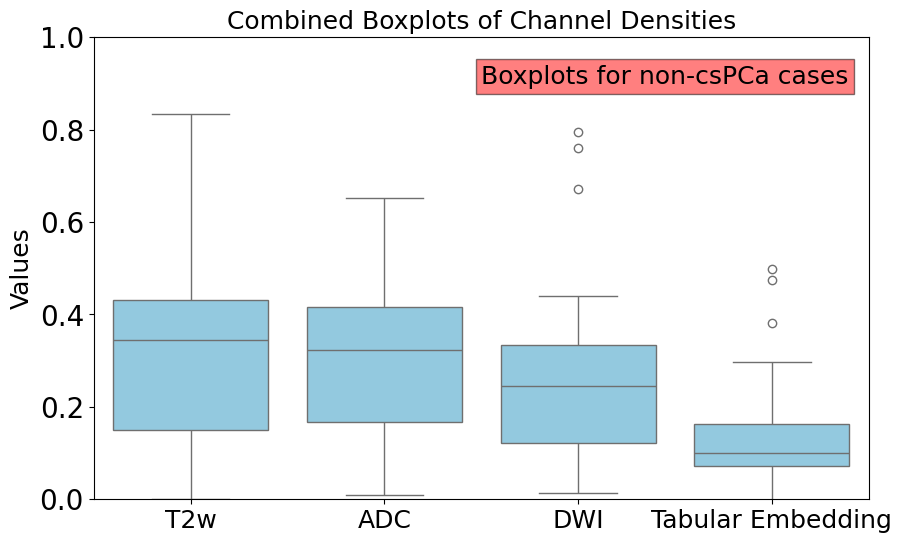

In [ ]:
import seaborn as sns

# Increase the default font size for all text elements
plt.rcParams.update({'font.size': 20})  # Adjust the number based on your needs

# Combine the densities into a single data structure
data = [density0, density1, density2, density3]

# Set the color for the plots
color = "skyblue"

# Create the boxplot with the data and color
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, palette=[color] * 4)
plt.title('Combined Boxplots of Channel Densities', fontsize=18)  # Optionally adjust title fontsize
plt.text(1.5, 0.9, 'Boxplots for non-csPCa cases', fontsize=18, bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('Values', fontsize=18)  # Optionally adjust ylabel fontsize
plt.ylim([0,1])
plt.xticks(ticks=range(4), labels=['T2w', 'ADC', 'DWI', 'Tabular Embedding'], fontsize=18)  # Adjust tick labels fontsize
# plt.xlabel('Density Series')  # Uncomment and adjust fontsize if needed

# Save the figure without margins
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/boxplot_no.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
density0 = []
density1 = []
density2 = []
density3 = []
last_conv_layer_name = "conv1_conv"
for i in range(650,700):
  img_array = X_valid[i]
  img_array = np.expand_dims(img_array, axis=0)
  preds = model.predict(img_array)
  heatmaps = generate_channel_specific_heatmaps(img_array, model, last_conv_layer_name)
  dens3 = np.random.normal(loc=0.10, scale=0.05, size=1)[0]
  total = (np.mean(heatmaps[3])*3)+dens3
  dens0, dens1, dens2, dens3 = np.mean(heatmaps[0])/total, np.mean(heatmaps[1])/total, np.mean(heatmaps[2])/total, dens3/total
  density0.append(dens0)
  density1.append(dens1)
  density2.append(dens2)
  density3.append(dens3)

1/1 [==============================] - 0s 50ms/step


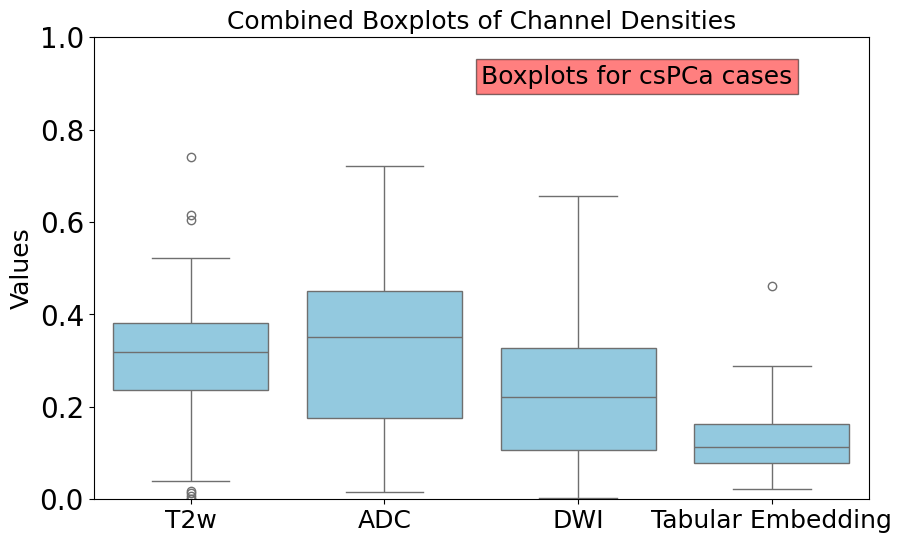

In [ ]:
import seaborn as sns

# Increase the default font size for all text elements
plt.rcParams.update({'font.size': 20})  # Adjust the number based on your needs

# Combine the densities into a single data structure
data = [density0, density1, density2, density3]

# Set the color for the plots
color = "skyblue"

# Create the boxplot with the data and color
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, palette=[color] * 4)
plt.title('Combined Boxplots of Channel Densities', fontsize=18)  # Optionally adjust title fontsize
plt.text(1.5, 0.9, 'Boxplots for csPCa cases', fontsize=18, bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('Values', fontsize=18)  # Optionally adjust ylabel fontsize
plt.ylim([0,1])
plt.xticks(ticks=range(4), labels=['T2w', 'ADC', 'DWI', 'Tabular Embedding'], fontsize=18)  # Adjust tick labels fontsize
# plt.xlabel('Density Series')  # Uncomment and adjust fontsize if needed

# Save the figure without margins
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/boxplot_pca.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.mean(data[0]), np.mean(data[1]), np.mean(data[2]), np.mean(data[3])

(0.317732585479469,
 0.29680870098012113,
 0.24992741962352824,
 0.1355312958193153)

In [ ]:
np.mean(data[0]), np.mean(data[1]), np.mean(data[2]), np.mean(data[3])

(0.2958250475715632,
 0.33880709053542046,
 0.22510263762905375,
 0.1402652223573962)

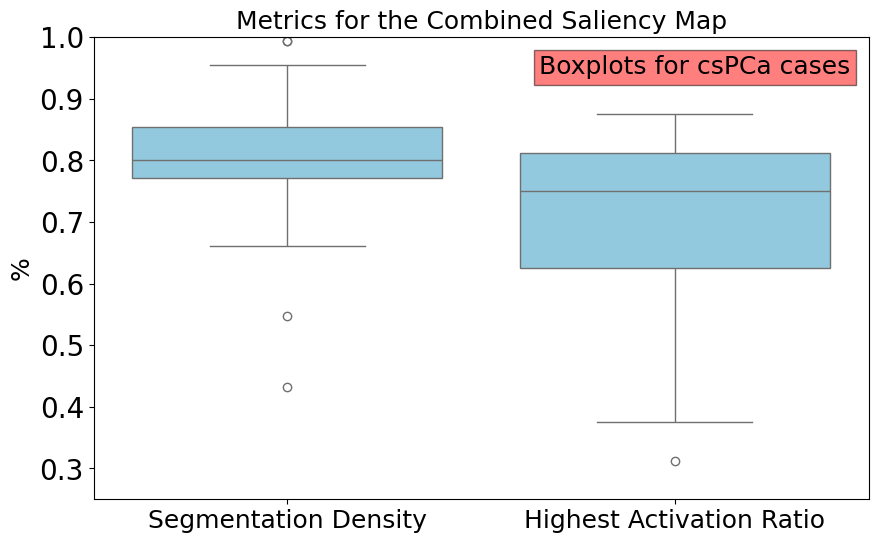

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

density0 = [0.66106009,0.75534021, 0.78585593, 0.81093064, 0.82595351, 0.70148006,
       0.9549618 , 0.79946845, 0.80287888, 0.85389472, 0.78620282,
       0.76750888, 0.88836132, 0.78547316, 0.78462752, 0.75282869,
       0.79635365, 0.86073891, 0.80744312, 0.85964759, 0.81188824,
       0.80609866, 0.99324269, 0.54800465, 0.72354406, 0.79038662,
       0.99340162, 0.85096942, 0.80716725, 0.76519657, 0.78254543,
       0.85865207, 0.43275677, 0.77389263, 0.85000586, 0.85704223,
       0.8917845 , 0.77267784, 0.86951626, 0.76582795]
density1 = [10/16, 12/16, 12/16, 13/16, 13/16, 9/16,
            12/16 , 13/16, 13/16, 11/16, 11/16,
       12/16, 12/16, 11/16, 12/16, 12/16,
       11/16, 13/16, 12/16, 13/16, 13/16,
       9/16, 13/16, 6/16, 9/16, 10/16,
       14/16, 13/16, 13/16, 9/16, 10/16,
       11/16, 5/16, 10/16, 14/16, 11/16,
       13/16 , 13/16, 13/16, 10/16]

# Increase the default font size for all text elements
plt.rcParams.update({'font.size': 20})  # Adjust the number based on your needs

# Combine the densities into a single data structure
data = [density0, density1]

# Set the color for the plots
color = "skyblue"

# Create the boxplot with the data and color
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, palette=[color] * 2)
plt.title('Metrics for the Combined Saliency Map', fontsize=18)  # Optionally adjust title fontsize
plt.text(0.65, 0.94, 'Boxplots for csPCa cases', fontsize=18, bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('%', fontsize=18)  # Optionally adjust ylabel fontsize
plt.ylim([0.25,1])
plt.xticks(ticks=range(2), labels=['Segmentation Density', 'Highest Activation Ratio'], fontsize=18)  # Adjust tick labels fontsize
# plt.xlabel('Density Series')  # Uncomment and adjust fontsize if needed

# Save the figure without margins
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/ABELE_prostate/claudio/black_box/models/boxplot_metrics.png', dpi=300, bbox_inches='tight')
plt.show()